# Import library

In [1]:
import numpy as np

import os
import torch
torch.manual_seed(0)

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18,resnet50,resnet101
from tqdm import tqdm
from typing import Dict
from torch import functional as F

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

# Set environment

In [2]:
DIR_INPUT = "../../../lyft/data/lyft-motion-prediction-autonomous-vehicles"
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
VALIDATION = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set Configuration

In [3]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet18',
        
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [1, 1],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
    
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },
    
    'train_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10000,
        'eval_every_n_steps': 500

        
    }
}

# Read validation set

In [7]:
import gc

val_cfg = cfg["val_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
val_zarr = ChunkedDataset(dm.require(val_cfg["key"])).open()
val_dataset = AgentDataset(cfg, val_zarr, rasterizer)
val_dataloader = DataLoader(val_dataset,
                              shuffle=val_cfg["shuffle"],
                              batch_size=val_cfg["batch_size"])
                              #num_workers=train_cfg["num_workers"])


    

# Read train set 

In [9]:
import gc

train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"])
                              #num_workers=train_cfg["num_workers"])

print(train_dataset)
gc.collect()



+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


13

# Read test set

In [14]:
import gc
# ===== INIT DATASET
test_cfg = cfg["test_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_dataset = AgentDataset(cfg, test_zarr, rasterizer)
test_dataloader = DataLoader(test_dataset,
                              shuffle=test_cfg["shuffle"],
                              batch_size=test_cfg["batch_size"],
                              num_workers=test_cfg["num_workers"])

gc.collect()




13

# Define Seq-to-Seq model

In [5]:
class EncoderLSTM_LyftModel(nn.Module):
    
    def __init__(self, cfg):
        super(EncoderLSTM_LyftModel, self).__init__()

        # input: x, y coordinate                
        self.input_sz  = 2
        
        # hidden_layer size
        self.hidden_sz = 128
        
        # num layer
        self.num_layer = 1
        
        # sequence length
        self.sequence_length = 11        
        
        self.Encoder_lstm = nn.LSTM(self.input_sz,self.hidden_sz,self.num_layer,batch_first=True)
       
    def forward(self,inputs):        
        '''
        Implemented Encoder with LSTM to extract 
        temporal information on history trajectories
        '''
        
        output,hidden_state = self.Encoder_lstm(inputs)
        
        return output,hidden_state
    
class DecoderLSTM_LyftModel(nn.Module):
    def __init__(self, cfg):
        super(DecoderLSTM_LyftModel, self).__init__()
        
        self.input_sz  = 128 
        self.hidden_sz = 128
        self.num_layer = 1
        self.sequence_len_de = 1
        self.batch_sz = 32
        
        
        self.encoderLSTM = EncoderLSTM_LyftModel(cfg)

        
        self.Decoder_lstm = nn.LSTM( self.input_sz,self.hidden_sz,self.num_layer,batch_first=True)


    def forward(self,inputs):
        '''
        With last hidden state, cell state trained on encoder, 
        predict 50 future trajectories with LSTM.
        Input to the decoder is zero vector of shape (batch_sz, 50, 128) 
        since most of the current position is at 0
        '''
        
        # Last hidden state and cell state on encoder
        _,hidden_state = self.encoderLSTM(inputs)
        
        # Dummy future trajectories
        result = torch.zeros((self.batch_sz, 50, 128))
        
        # Input to decoder
        inout_to_dec = torch.zeros(inputs.shape[0],self.sequence_len_de,self.input_sz).to(device)
        
        # Predict 50 future trajectories consecutively
        for i in range(50):
            inout_to_dec,hidden_state = self.Decoder_lstm(inout_to_dec,(hidden_state[0],hidden_state[1]) )          
            result[:,i,:] = inout_to_dec[:,0,:]
        return result

# Generator Implementation

In [7]:
class Generator(nn.Module):
    def __init__(self, starting_shape):
        super(Generator, self).__init__()
        self.input_sz  = 128 
        self.hidden_sz = 256 
        self.num_layer = 1
        self.sequence_len_de = 1
        self.interlayer = 512
        self.DecoderLSTM_LyftModel = DecoderLSTM_LyftModel(cfg)
        
        num_targets = 2
        
        self.fcn_en_state_dec_state = nn.Sequential(nn.Linear(in_features=self.hidden_sz, out_features=self.hidden_sz),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(in_features = self.hidden_sz, out_features = self.interlayer),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(in_features = self.interlayer, out_features = self.hidden_sz),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(in_features=self.hidden_sz, out_features=num_targets))


    def forward(self,inputs):
        '''
        With latent temporal vector from decoder, 
        add noise to the generator and generate
        50 future trajectories of each agents
        '''
        
        # Temporal vector from decoder
        decoderLSTM = self.DecoderLSTM_LyftModel(inputs)

        # Noise from Gaussian Distribution
        noise_gen = torch.randn(decoderLSTM.shape, device=device) 
        
        # Add noise to the latent vector
        combine = torch.cat([decoderLSTM, noise_gen], dim = 2)
        
        # Generate Trajectories
        fc_out = self.fcn_en_state_dec_state(combine.squeeze(dim=0))
        
        return fc_out

    

# Discriminator Implementation

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.lstm_hidden = 128
        self.input_sz = 2
        self.num_layer = 1
        self.batch_sz = 32
        
        self.hidden_sz_1 = 6400
        self.hidden_sz_2 = 3200
        self.hidden_sz_3 = 1600
        self.hidden_sz_4 = 800

            
        self.fc= nn.Sequential(
            nn.Linear(in_features=self.hidden_sz_1, out_features=self.hidden_sz_2),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.hidden_sz_2, out_features=self.hidden_sz_3),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.hidden_sz_3, out_features=self.hidden_sz_4),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.hidden_sz_4, out_features=1)
        )
        self.lstm = nn.LSTM(self.input_sz,self.lstm_hidden,self.num_layer,batch_first=True)


        
    def forward(self, input):
        '''
        Input to the discriminator is either real trajectory or
        generated fake trajectory. Discriminator would differentiate
        if trajectories are real/fake with LSTM and FC
        '''        
        output, _ = self.lstm(input)
        output = output.reshape((self.batch_sz, -1))
        fc = self.fc(output)
        return fc
    
    

In [9]:
import matplotlib.pyplot as plt

# GAN Implementation

In [10]:
# Use this to put tensors on GPU/CPU automatically when defining tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

class GAN(nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        self.num_epoch = 2
        self.batch_size = 32
        self.log_step = 1000 
        self.visualize_step = 1
        self.code_size = 64
        self.learning_rate = 1e-3
        self.vis_learning_rate = 1e-2
        self.val = 1000
        
        # Define L2 Loss for the generator
        self._l2_loss = nn.MSELoss()

        # Define the generator and both discriminator 
        self._discriminator = Discriminator().to(device)
        self._generator = Generator(self.code_size).to(device)

        # Loss function for the discriminator
        self._classification_loss = nn.BCEWithLogitsLoss()

        # Apply weight initialization 
        self._discriminator.apply(self._weight_initialization)
        self._generator.apply(self._weight_initialization)

        # Hyper parameter for the Adam Optimizer
        betas = (0.5, 0.999)
        
        # Optimizer for Generator and Discriminator
        self._generator_optimizer = torch.optim.Adam(self._generator.parameters(), lr = self.learning_rate, betas = betas)
        self._discriminator_optimizer = torch.optim.Adam(self._discriminator.parameters(), lr = self.learning_rate, betas = betas)

    # custom weights initialization for both networks
    # apply the custom weight initialization
    
    def _weight_initialization(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    # Discriminator Loss
    def _loss(self, logits, labels):
        return self._classification_loss(logits, labels)
    
    # Generator Loss
    def _reconstruction_loss(self, generated, target):
        return self._l2_loss(generated, target)

    # Training function
    def forward(self, train_dataloader):
        for epoch in range(self.num_epoch):
            # Save train loss for discriminator and generator
            dis_losses = []
            gen_losses = []
            
            # Save validation loss for discriminator and generator
            val_dis_losses = []
            val_gen_losses = []

            step = 0

            # smooth the loss curve so that it does not fluctuate too much
            smooth_factor = 0.95
            plot_dis_s = 0
            plot_gen_s = 0
            plot_ws = 0

            max_steps = int(len(iter(train_dataloader)))
            
            # Fake label for discriminator
            fake_label = torch.zeros([self.batch_size, 1], device=device)
            
            # Real label for discriminator            
            real_label = torch.ones([self.batch_size, 1], device=device)
            
            # Train generator and discriminator
            self._generator.train()
            self._discriminator.train()
            
            print('Start training ...')

            progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))

            tr_it = iter(train_dataloader)

            
            for itr in progress_bar:
                try:
                    data = next(tr_it)
                except StopIteration:
                    tr_it = iter(train_dataloader)
                    data = next(tr_it)
                step += 1

                ################################################################################
                # Train the discriminator                                                      #
                ################################################################################
                history_positions = torch.flip(data['history_positions'], [1]).to(device)
#                 history_availabilities = torch.flip(data['history_availabilities'], [1]).to(device)
                target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
                targets_position = data["target_positions"].to(device) 

                # Eliminate discriminator gradients
                self._discriminator_optimizer.zero_grad()

                # Calculate BCE loss on discriminator
                real_dis_out = self._discriminator(targets_position)
                real_dis_loss = self._loss(real_dis_out, real_label)

                # Calculate real discriminator loss gradients
                real_dis_loss.backward()

                ################################################################################
                # Train the discriminator with an all fake batch                               #
                ################################################################################
                # Detach the fake samples from the gradient calculation 
                # when feeding to the discriminator, we don't want the discriminator to 
                # receive gradient info from the Generator

                fake_samples = self._generator(history_positions).detach() 
                fake_dis_out = self._discriminator(fake_samples)
                
                numGenerated = fake_dis_out.shape[0]

                fake_dis_label = fake_label[:numGenerated] 
                fake_dis_loss = self._loss(fake_dis_out, fake_dis_label).requires_grad_()


                # Calculate fake discriminator loss gradients
                fake_dis_loss.backward()
                
                # Update the discriminator weights                
                self._discriminator_optimizer.step()
                ################################################################################
                # Train the generator                                                          #
                ################################################################################                
                # Get new samples from updated discriminator. No need to detach
                # from gradient calculation here, we want the Generator to receive
                # gradient info from the discriminator so it can learn better.

                # Eliminate all generator gradients first
                self._generator_optimizer.zero_grad()

                # Generate future trajectories with history positions
                fake_samples_gen = self._generator(history_positions)


                fake_dis_out_gen = self._discriminator(fake_samples_gen)

                # Calculate the generator loss gradients
                generated_Num = fake_dis_out_gen.shape[0]
                
                # Update Generator BCE loss
                gen_loss = self._loss(fake_dis_out_gen, real_label[:generated_Num])


                # Update the generator weights
                gen_loss.backward()
                self._generator_optimizer.step()
                
                # Add up discriminator loss
                dis_loss = real_dis_loss + fake_dis_loss

                # Apply smoothing factors for the plot
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                # Validation
                
                with torch.no_grad():
                    try:
                        val_data = next(vl_it)
                    except:
                        vl_it = iter(val_dataloader)
                        val_data = next(vl_it)

                    self._generator.eval()
                    self._discriminator.eval()

                    # Fetch Validation data
                    val_history_positions = torch.flip(val_data['history_positions'], [1]).to(device)
#                     val_history_yaws = torch.flip(val_data['history_yaws'], [1]).to(device)
                    
#                     val_history_availabilities = torch.flip(val_data['history_availabilities'], [1]).to(device)
                    val_target_availabilities = val_data["target_availabilities"].unsqueeze(-1).to(device)
                    val_targets_position = val_data["target_positions"].to(device)
                    
                    # Calculate Validation loss of discriminator
                    val_real_dis_out = self._discriminator(val_targets_position)
                    val_real_dis_loss = self._loss(val_real_dis_out, real_label)

                    # Calculate Validation loss of generator            
                    val_fake_samples_gen = self._generator(val_history_positions)
                    val_gen_loss = self._loss(val_fake_samples_gen, val_targets_position)

                    # Calculate Validation loss of discriminator                    
                    val_fake_dis_out = self._discriminator(val_fake_samples_gen)

                    val_fake_dis_label = fake_label[:numGenerated] 
                    val_fake_dis_loss = self._loss(val_fake_dis_out, val_fake_dis_label)

                    val_dis_loss = val_real_dis_loss + val_fake_dis_loss

                    # Plot Validation loss
                    
                    val_plot_dis_s = plot_dis_s * smooth_factor + val_dis_loss * (1 - smooth_factor)
                    val_plot_gen_s = plot_gen_s * smooth_factor + val_gen_loss * (1 - smooth_factor)
                    val_plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                    val_dis_losses.append(val_plot_dis_s / val_plot_ws)
                    val_gen_losses.append(val_plot_gen_s / val_plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

                # Save our loss graph
                    
                if step % self.val == 0:
                    fig = plt.figure(figsize = (8, 8))   
                    plt.plot(dis_losses)
                    plt.plot(val_dis_losses)
                    
                    plt.title('discriminator loss')
                    plt.xlabel('iterations')
                    plt.ylabel('loss')
                    plt.show()

                    plt.plot(gen_losses)
                    plt.plot(val_gen_losses)                    
                    plt.title('generator loss')
                    plt.xlabel('iterations')
                    plt.ylabel('loss')
                    plt.show()
            
            # Save model weights
            
            torch.save(gan.state_dict(), "gan" + str(epoch)+ ".pt")

            # Save loss graph
            
            fig = plt.figure(figsize = (8, 8))   

            plt.plot(dis_losses)
            plt.plot(val_dis_losses)

            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.savefig("discriminator_v1_epoch_" + str(epoch) + '.png')

            plt.plot(gen_losses)
            plt.plot(val_gen_losses)                    
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.savefig("generator_v1_epoch_" + str(epoch) + '.png')

            print('... Done!')


# Train GAN Model

  0%|          | 0/10000 [00:00<?, ?it/s]

Start training ...


 10%|▉         | 999/10000 [43:02<7:49:03,  3.13s/it] 

Iteration 1000/703023: dis loss = 1.0661, gen loss = 1.0655


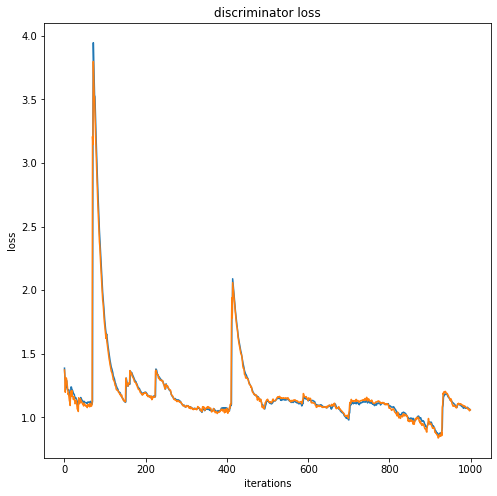

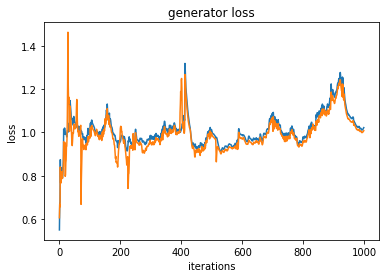

 20%|█▉        | 1999/10000 [1:33:44<5:51:16,  2.63s/it] 

Iteration 2000/703023: dis loss = 1.1789, gen loss = 0.7479


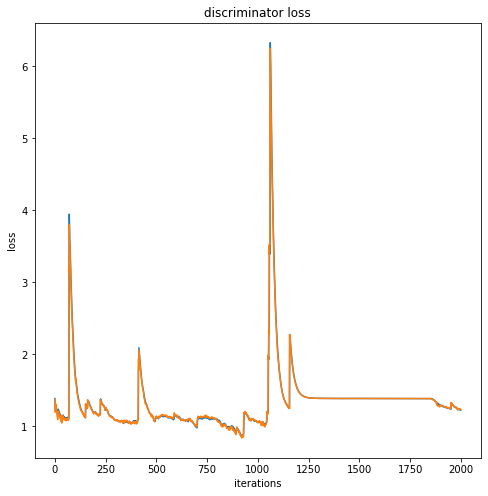

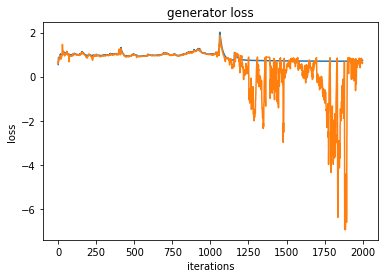

 22%|██▏       | 2208/10000 [1:44:57<6:08:37,  2.84s/it] 

In [ ]:
gan = GAN()
gan(train_dataloader)



# Load model saved

In [12]:
ganModel = GAN()
ganModel.load_state_dict(torch.load("./vanila_v1/gan0.pt"))
ganModel

GAN(
  (_l2_loss): MSELoss()
  (_discriminator): Discriminator(
    (fc): Sequential(
      (0): Linear(in_features=6400, out_features=3200, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=3200, out_features=1600, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1600, out_features=800, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=800, out_features=1, bias=True)
    )
    (lstm): LSTM(2, 128, batch_first=True)
  )
  (_generator): Generator(
    (DecoderLSTM_LyftModel): DecoderLSTM_LyftModel(
      (encoderLSTM): EncoderLSTM_LyftModel(
        (Encoder_lstm): LSTM(2, 128, batch_first=True)
      )
      (Decoder_lstm): LSTM(128, 128, batch_first=True)
    )
    (fcn_en_state_dec_state): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, 

# Predict on test set

In [15]:
future_coords_offsets_pd = []
real_target = []
target_availabilities = []
timestamps = []
agent_ids = []
num_iter = 0

# Start testing
with torch.no_grad():
    # load test set
    dataiter = tqdm(test_dataloader)
    
    for data in dataiter:
        history_positions = torch.flip(data['history_positions'], [1]).to(device)
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy())
        real_target.append(data["target_positions"])
        target_availabilities.append(data["target_availabilities"])
        

        # Set the generator to evaluation mode, to make batchnorm stats stay fixed
        ganModel._generator.eval()
        future_coords_offsets_pd.append(ganModel._generator(history_positions))
        num_iter += 1
        
        # Test on first 1000 batches
        if num_iter == 1000:
            break
            
# Save the result            
torch.save(future_coords_offsets_pd, "ganv1_future.pt")
torch.save(real_target, "ganv1_target.pt")
torch.save(target_availabilities, "ganv1_t_avail.pt")
torch.save(timestamps, "ganv1_timestamps.pt")
torch.save(agent_ids, "ganv1_ids.pt")

  1%|          | 999/185990 [02:41<8:19:38,  6.17it/s] 


# Preprocess result

In [16]:
future_coords_offsets_pd = torch.stack(future_coords_offsets_pd)
target_availabilities = torch.stack(target_availabilities)
target_availabilities = target_availabilities.view(1000, 32, 50, 1)
real_target = torch.stack(real_target)
real_target  = real_target * target_availabilities
future_coords_offsets_pd = future_coords_offsets_pd * target_availabilities

# Caculate MSE loss on test set

In [17]:
loss = nn.MSELoss(reduction = 'mean')
print(loss(future_coords_offsets_pd, real_target))

tensor(78.5733)
